# Import packages

In [1]:
import pandas as pd
import numpy as np
#import cvxopt
import cvxpy as cp

import matplotlib.pyplot as plt

# Create toy dataset

In [2]:
# Problem dimensions
n = 10
m_var = 0.01

In [3]:
# Weights
w = np.random.uniform(size=n)
w /= np.sum(w)

print(w)
print(np.sum(w))

[0.12491694 0.02916595 0.08120811 0.03769151 0.13048453 0.12004541
 0.07679445 0.10572404 0.1483747  0.14559436]
1.0


In [4]:
# Overall separation rate calibrated by the model
overall_lambda = 0.1

In [5]:
# CIPD relative spearation rate estimates
m = np.random.normal(overall_lambda,m_var,n)
m = np.asarray([i if i>0 else 0.001 for i in m])

print(m)

[0.10122705 0.09677575 0.08570268 0.10276224 0.09348407 0.09199016
 0.10700748 0.09010938 0.09174794 0.10143809]


# Optimization step

In [6]:
# Initialize matrix
KKTM = np.zeros((n+1,n+1))

In [7]:
# Create matrix blocks
KKTM11 = np.zeros((n,n))
np.fill_diagonal(KKTM11, 1)

print(KKTM11)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [8]:
# Assign blocks to the KKT matrix
KKTM[:n,:n] = KKTM11
KKTM[n,:n] = w
KKTM[:n,n] = (-1/2)*w

print(KKTM)

[[ 1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.06245847]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.01458298]
 [ 0.          0.          1.          0.          0.          0.
   0.          0.          0.          0.         -0.04060406]
 [ 0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.         -0.01884576]
 [ 0.          0.          0.          0.          1.          0.
   0.          0.          0.          0.         -0.06524227]
 [ 0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.         -0.0600227 ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.         -0.03839723]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.          0.  

In [9]:
# Get target
target = np.append(m,overall_lambda)

print(target)

[0.10122705 0.09677575 0.08570268 0.10276224 0.09348407 0.09199016
 0.10700748 0.09010938 0.09174794 0.10143809 0.1       ]


In [10]:
# Estimate the solution
sol_est = np.linalg.inv(KKTM)@target

In [11]:
# Unpack the solution
x = sol_est[:n]
mu = sol_est[n]

In [12]:
print("Estimated overall mean (weighted average): {}".format(np.dot(x,w)))

Estimated overall mean (weighted average): 0.09999999999999999


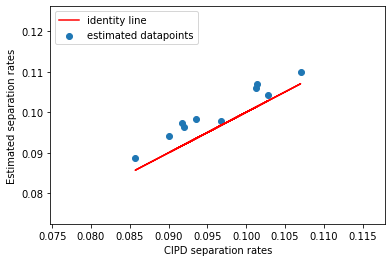

In [13]:
plt.scatter(m,x,label="estimated datapoints")
plt.plot(m,m,c='red',label="identity line")
plt.xlabel("CIPD separation rates")
plt.ylabel("Estimated separation rates")
plt.legend(loc='upper left')

plt.show()

# CVXPY optimization

In [14]:
# Define and solve the CVXPY problem.
x = cp.Variable(n)
cost = cp.sum_squares(x - m)

# Define arrays for optimization
G = - KKTM11
h = np.zeros(n)
b = overall_lambda
A = w

prob = cp.Problem(cp.Minimize(cost),
                 [G @ x <= h,
                  A @ x == b])
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)


The optimal value is 0.00016150882732076434
A solution x is
[0.10588425 0.09786312 0.08873031 0.10416747 0.09834885 0.09646575
 0.10987056 0.09405103 0.09727971 0.1068662 ]
A dual solution corresponding to the inequality constraints is
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


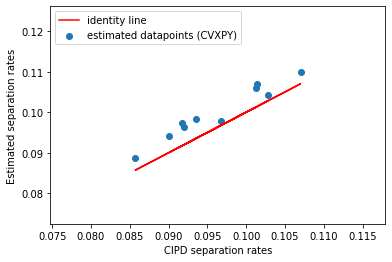

In [15]:
plt.scatter(m,x.value,label="estimated datapoints (CVXPY)")
plt.plot(m,m,c='red',label="identity line")
plt.xlabel("CIPD separation rates")
plt.ylabel("Estimated separation rates")
plt.legend(loc='upper left')

plt.show()